Leveraging time series models like ARIMA, SARIMA, LSTM, and others, we conduct an in-depth analysis for trend prediction and price forecasting in quantitative trades. Trained on our dataset, these models undergo rigorous testing using metrics such as accuracy and validation loss. Our focus on time series data allows us to capture temporal dependencies essential for predicting market trends. Through systematic evaluation, we aim to reveal the performance nuances of each model and present the results through insightful plots

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('btc_1h.csv')

In [200]:
df.head()

datetime      open      high       low     close      volume
0  2018-01-01 05:30:00  13715.65  13715.65  13400.01  13529.01  443.356199
1  2018-01-01 06:30:00  13528.99  13595.89  13155.38  13203.06  383.697006
2  2018-01-01 07:30:00  13203.00  13418.43  13200.00  13330.18  429.064572
3  2018-01-01 08:30:00  13330.26  13611.27  13290.00  13410.03  420.087030
4  2018-01-01 09:30:00  13434.98  13623.29  13322.15  13601.01  340.807329

In [202]:
df_lstm = df.drop(columns='datetime')

In [203]:
df_lstm.head()

open      high       low     close      volume
0  13715.65  13715.65  13400.01  13529.01  443.356199
1  13528.99  13595.89  13155.38  13203.06  383.697006
2  13203.00  13418.43  13200.00  13330.18  429.064572
3  13330.26  13611.27  13290.00  13410.03  420.087030
4  13434.98  13623.29  13322.15  13601.01  340.807329

In [197]:
df = df.dropna()

In [105]:
df.set_index('datetime',inplace=True)

In [201]:
df.isnull().sum()

datetime    0
open        0
high        0
low         0
close       0
volume      0
dtype: int64

In [37]:
df.shape

(35664, 5)

Plotting the close price vs dateTime

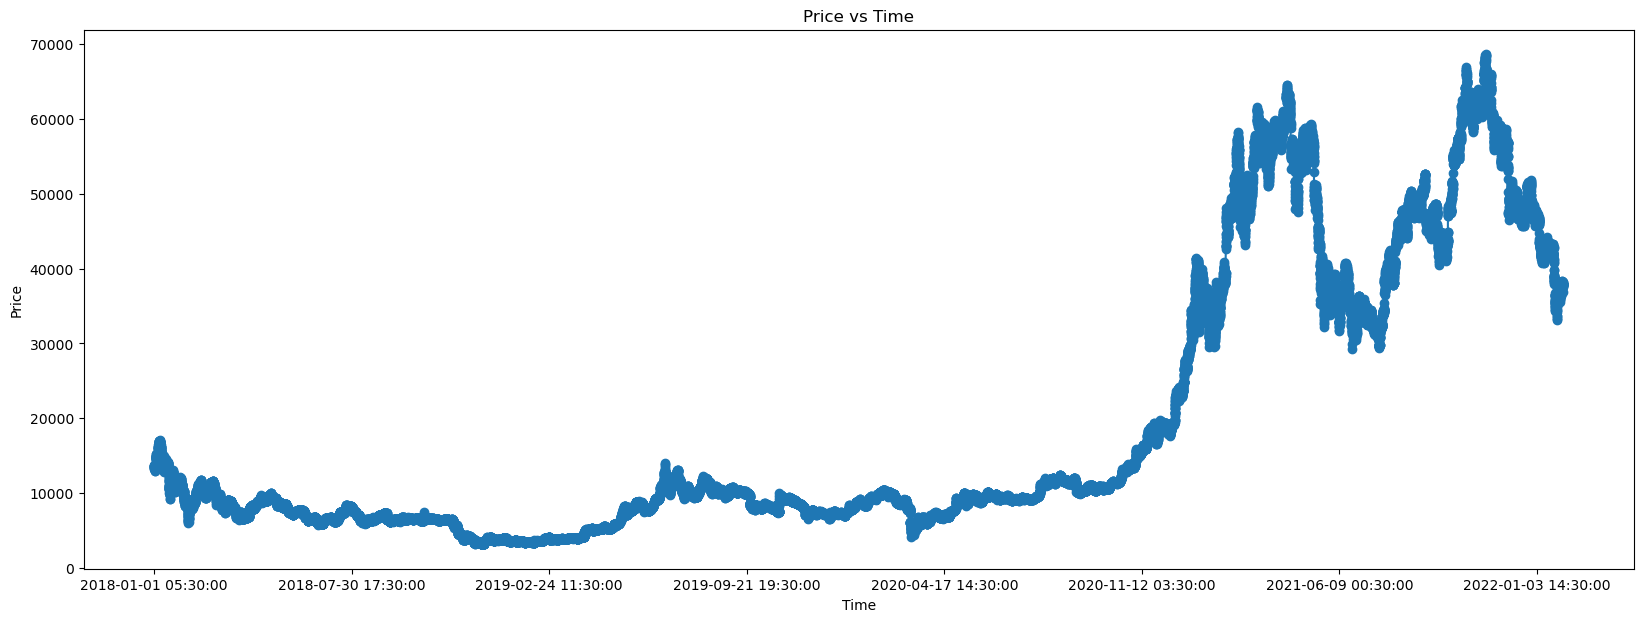

In [38]:
df['close'].plot(title='Price vs Time', xlabel='Time', ylabel='Price', marker='o', linestyle='-',figsize=(20,7))
plt.show()

In [39]:
df.skew()

open      1.220629
high      1.217938
low       1.223607
close     1.220500
volume    4.560364
dtype: float64

Applying Box Cox Transformation for normalizing

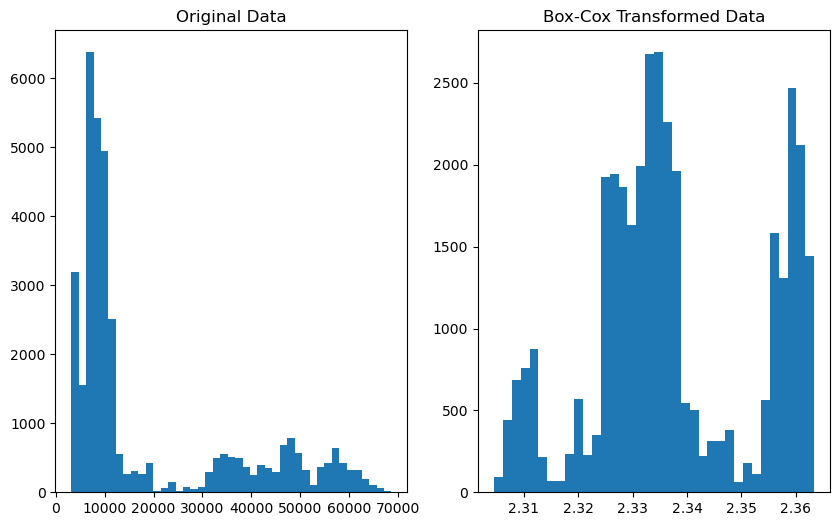

In [40]:
import numpy as np
from scipy.stats import boxcox
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
transformed_data, lambda_value = boxcox(df['close'])

# Plot original and transformed data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['close'], bins='auto')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins='auto')
plt.title('Box-Cox Transformed Data')

plt.show()

In [41]:
import seaborn as sns

<Axes: ylabel='Density'>

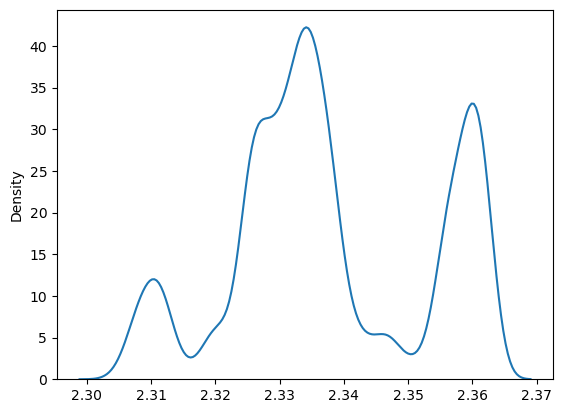

In [42]:
sns.kdeplot(transformed_data)

In [56]:
df_updated.head()

close      high      open       low    volume
0  2.341535  2.345021  2.341613  2.336651  5.533071
1  2.341081  2.344858  2.341359  2.336309  5.414430
2  2.341260  2.344613  2.340905  2.336372  5.506217
3  2.341371  2.344879  2.341084  2.336498  5.488873
4  2.341634  2.344895  2.341230  2.336543  5.316739

In [44]:
df_updated = pd.DataFrame({'close':transformed_data})

In [47]:
df_updated['high'] = transformed_data

In [52]:
df_updated['low'] = transformed_data

In [ ]:
df_updated['volume'] = transformed_data

In [50]:
df_updated['open'] = transformed_data

In [55]:
df_updated['volume'] = transformed_data

In [57]:
df_updated.skew()     

close     0.120915
high      0.120876
open      0.120907
low       0.120988
volume   -0.012182
dtype: float64

In [12]:
transformed_data, lambda_value = boxcox(df['close'])

In [49]:
transformed_data, lambda_value = boxcox(df['open'])

In [46]:
transformed_data, lambda_value = boxcox(df['high'])

In [51]:
transformed_data, lambda_value = boxcox(df['low'])

Applying Yeo Johnson Method for normalizing the volume feature

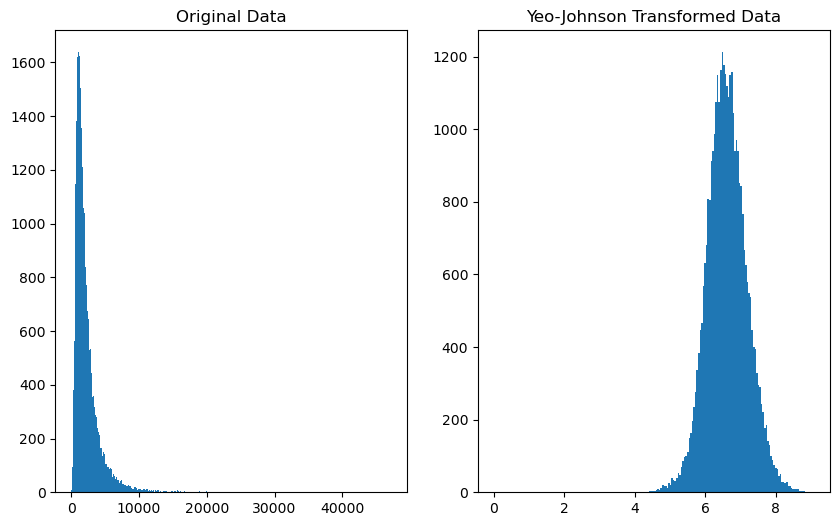

In [54]:
import numpy as np
from scipy.stats import yeojohnson
import matplotlib.pyplot as plt

# Assuming 'data' is your dataset
transformed_data, lambda_value = yeojohnson(df['volume'])

# Plot original and transformed data
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(df['volume'], bins='auto')
plt.title('Original Data')

plt.subplot(1, 2, 2)
plt.hist(transformed_data, bins='auto')
plt.title('Yeo-Johnson Transformed Data')

plt.show()

In [60]:
from sklearn.metrics import r2_score

In [252]:
df_updated.shape

(35664, 5)

Applying Stack LSTM as model

In [323]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function to prepare the dataset for LSTM
def prepare_data(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data.iloc[i:(i + time_steps)].values)
        y.append(data.iloc[i + time_steps].values)
    return np.array(X), np.array(y)

# Set the number of time steps
time_steps = 100  # You can adjust this based on your dataset

# Prepare the dataset
X, y = prepare_data(df_updated, time_steps)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the stacked LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=df_updated.shape[1]))  # Output layer with the same number of features

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model with validation data
history = model.fit(X_train, y_train, epochs=10, batch_size=40, validation_data=(X_val, y_val))

# Now, you can use the trained model for predictions
# Adjust this part based on your use case
# For example, if you want to predict the next time step:
new_data = df_updated[-time_steps:].values.reshape(1, time_steps, df_updated.shape[1])
prediction = model.predict(new_data)

print("Predicted values:", prediction)

Epoch 1/10
712/712 [==============================] - 55s 65ms/step - loss: 0.1711 - val_loss: 0.0794
Epoch 2/10
712/712 [==============================] - 50s 70ms/step - loss: 0.0726 - val_loss: 0.0753
Epoch 3/10
712/712 [==============================] - 52s 73ms/step - loss: 0.0638 - val_loss: 0.0608
Epoch 4/10
712/712 [==============================] - 47s 65ms/step - loss: 0.0624 - val_loss: 0.0591
Epoch 5/10
712/712 [==============================] - 48s 67ms/step - loss: 0.0610 - val_loss: 0.0672
Epoch 6/10
712/712 [==============================] - 48s 68ms/step - loss: 0.0600 - val_loss: 0.0592
Epoch 7/10
712/712 [==============================] - 48s 67ms/step - loss: 0.0591 - val_loss: 0.0603
Epoch 8/10
712/712 [==============================] - 47s 66ms/step - loss: 0.0585 - val_loss: 0.0599
Epoch 9/10
712/712 [==============================] - 48s 67ms/step - loss: 0.0587 - val_loss: 0.0573
Epoch 10/10
1/1 [==============================] - 1s 1s/step
Predicted values: [[

In [322]:
df_updated[-time_steps:]

close      high      open       low    volume
35564  2.356539  2.360150  2.356588  2.351695  7.104709
35565  2.356601  2.359951  2.356359  2.351665  6.758443
35566  2.356701  2.360053  2.356420  2.351733  6.604906
35567  2.356766  2.360117  2.356520  2.351805  6.767402
35568  2.356389  2.360092  2.356585  2.351529  7.144724
...         ...       ...       ...       ...       ...
35659  2.356986  2.360332  2.356750  2.352032  6.220869
35660  2.357001  2.360339  2.356805  2.352077  6.083385
35661  2.357019  2.360369  2.356820  2.352119  5.943615
35662  2.357049  2.360488  2.356838  2.352168  6.624758
35663  2.356708  2.360399  2.356868  2.351862  7.029665

[100 rows x 5 columns]

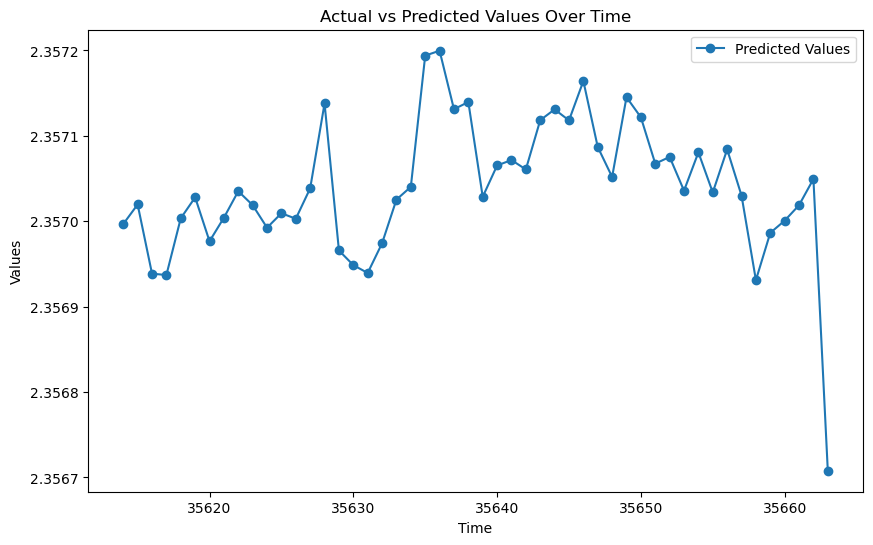

In [332]:
time_index = df_updated.index[-500:]
plt.figure(figsize=(10, 6))
# plt.plot(time_index, df_updated.iloc[-time_steps:].values[][0], label='Actual Values', marker='o')
plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Actual Values', marker='o')
# plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')
plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Predicting Value vs Actual Value

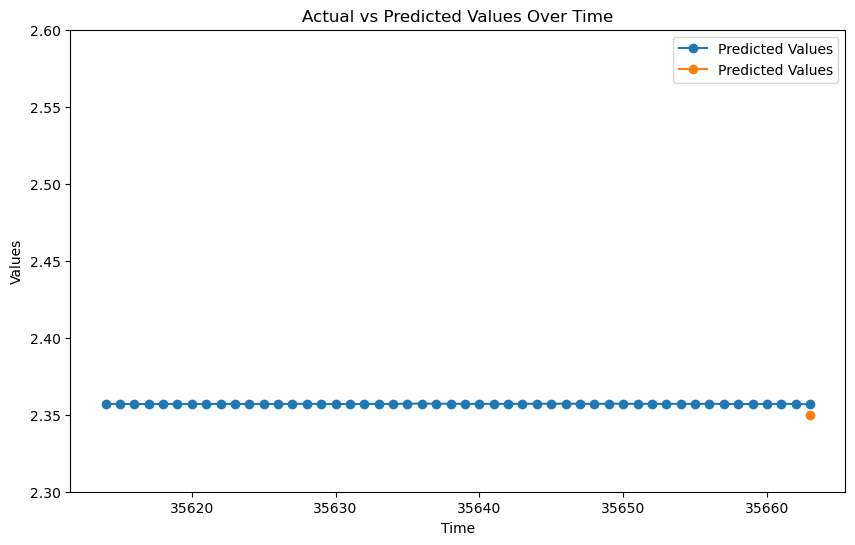

In [337]:
import numpy as np

time_index = df_updated.index[-500:]

plt.figure(figsize=(10, 6))

# Set the desired y-axis tick values
desired_y_values = np.arange(2.3, 2.6, 0.05)

plt.plot(df_updated.index[-50:], df_updated['close'].values[df_updated.index[-50:]], label='Predicted Values', marker='o')
plt.plot(df_updated.index[-1:], prediction[0][0], label='Predicted Values', marker='o')

plt.title('Actual vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')

# Set y-axis tick values
plt.yticks(desired_y_values)

plt.legend()
plt.show()

In [84]:
# Extract the true values corresponding to the predicted time steps
true_values_predicted_time_steps = df_updated['close'].values

# Squeeze the prediction array to remove the singleton dimension
prediction_last_time_steps = np.squeeze(prediction[-5:])

Plotting ACF and PACF 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['shifted_close'], ax=ax1, lags=100)
plot_pacf(df['shifted_close'], ax=ax2, lags=100)

plt.show()

In [345]:
df['shifted_close'] = df['close'].shift(1)

Applying ARIMA model

In [346]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Choose a specific feature for ARIMA (e.g., 'close' for stock closing prices)
feature_name = 'shifted_close'

# Split the dataset into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df['shifted_close'][:train_size], df['shifted_close'][train_size:]

# Define the ARIMA model
order = (1, 1, 1)  # Example order parameters; you may need to adjust based on your data
model = ARIMA(train, order=order)

# Fit the ARIMA model
model_fit = model.fit()

# Make predictions on the test set
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')

# Evaluate the model performance
mae = mean_absolute_error(test, predictions)
print("Mean aboslute Error:", mae)

# Visualize the results
# plt.plot(test.index, test.values, label='Actual')
# plt.plot(test.index, predictions, label='ARIMA Predictions')
# plt.legend()
# plt.show()

Mean aboslute Error: 11453.439280002256
